<a href="https://colab.research.google.com/github/naenumtou/dataScienceLab/blob/main/RVModelRandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Change working directory
%cd /content/drive/My Drive/Colab Notebooks/usedcarData

/content/drive/My Drive/Colab Notebooks/usedcarData


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import warnings


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Config
pd.options.display.float_format = '{:.4f}'.format #Table format
%config InlineBackend.figure_format = 'retina' #Retina display
warnings.filterwarnings('ignore') #Off warnings

In [ ]:
#Read dataset
df = pd.read_csv('vehicles.csv')
print(f'Total row: {df.shape[0]}\nTotal columns: {df.shape[1]}')

Total row: 435849
Total columns: 25


In [ ]:
# Keep only features used
useFeatures = [
               'price',
               'year',
               'odometer',
               'condition',
               'cylinders',
               'fuel',
               'title_status',
               'transmission',
               'drive',
               'size',
               'type',
               'paint_color'
]
df = df[useFeatures]
print(f'Total columns after exclusion: {df.shape[1]}')

Total columns after exclusion: 12


In [ ]:
# Data assessment
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,435849.0000,134912.7142,16908570.0319,0.0000,4900.0000,9995.0000,17989.0000,3647256576.0000
year,434732.0000,2009.8665,9.3125,1900.0000,2007.0000,2012.0000,2015.0000,2021.0000
odometer,360701.0000,98975.9043,113499.0190,0.0000,47333.0000,91188.0000,134736.0000,10000000.0000


In [ ]:
# Data cleansing
# 'price' --> [750, 100000)
df = df.query(
    "price >= 750 & price < 100000"
)
print(f'Total rows after exclusion: {df.shape[0]}')

Total rows after exclusion: 394619


In [ ]:
# Missing values
print(df.isnull().sum())

price                0
year              1093
odometer         63849
condition       160208
cylinders       146013
fuel              2747
title_status      1599
transmission      1877
drive           107637
size            267268
type            104705
paint_color     118278
dtype: int64


In [ ]:
# Data assumption
# 'year' --> Fill missing values with mode
df['year'] = df['year'].fillna(df['year'].mode()[0])

# Create car age from year
df['age'] = datetime.datetime.now().year - df['year']
df = df.drop(['year'], axis = 1)

# Re-checking missing value
print(df.isnull().sum())

price                0
odometer         63849
condition       160208
cylinders       146013
fuel              2747
title_status      1599
transmission      1877
drive           107637
size            267268
type            104705
paint_color     118278
age                  0
dtype: int64


In [ ]:
# 'odometer' --> Fill missing values with mean
df['odometer'] = df['odometer'].fillna(df['odometer'].mean())

#Re-checking missing value
print(df.isnull().sum())

price                0
odometer             0
condition       160208
cylinders       146013
fuel              2747
title_status      1599
transmission      1877
drive           107637
size            267268
type            104705
paint_color     118278
age                  0
dtype: int64


In [ ]:
# 'condition' --> Remove missing
df = df[df['condition'].notnull()]

# Transform condition to values 'excellent' = 6 -> 'salvage' = 1
criteria = [
            df['condition'] == 'excellent',
            df['condition'] == 'like new',
            df['condition'] == 'new',
            df['condition'] == 'good',
            df['condition'] == 'fair',
            df['condition'] == 'salvage'
]
flag = [6, 5, 4, 3, 2, 1]
df['condition'] = np.select(criteria, flag)

# Re-checking missing value
print(df.isnull().sum())

price                0
odometer             0
condition            0
cylinders        45453
fuel                12
title_status         0
transmission       154
drive            38509
size            119431
type             37066
paint_color      40714
age                  0
dtype: int64


In [ ]:
# 'drive', 'size', 'paint_color' --> Remove missing
df = df[df['drive'].notnull()]
df = df[df['size'].notnull()]
df = df[df['paint_color'].notnull()]

# Re-checking missing value
print(df.isnull().sum())

price              0
odometer           0
condition          0
cylinders       2299
fuel               0
title_status       0
transmission      20
drive              0
size               0
type            2358
paint_color        0
age                0
dtype: int64


In [ ]:
# 'title_status' --> Remove 'missing' and 'parts only'
df = df[df['title_status'] != 'missing']
df = df[df['title_status'] != 'parts only']

# Re-checking missing value
print(df.isnull().sum())

price              0
odometer           0
condition          0
cylinders       2286
fuel               0
title_status       0
transmission      20
drive              0
size               0
type            2351
paint_color        0
age                0
dtype: int64


In [ ]:
# 'cylinders', 'fuel', 'transmission', 'type' --> Fill missing values with 'other'

for col in ['cylinders', 'fuel', 'transmission', 'type']:
  df[col] = df[col].replace(np.nan, 'other')

# Re-checking missing value
print(df.isnull().sum())

price           0
odometer        0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
age             0
dtype: int64


In [ ]:
# Reset index
df = df.reset_index(drop = True)

# Categorical transformation --> One-hot encoding
cols = ['cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']

for col in cols:
  dummies = pd.get_dummies(df[col], prefix = col)
  df = df.drop(
      [col],
      axis = 1
  )
  df = pd.merge(
      df,
      dummies,
      how = 'left',
      left_index = True,
      right_index = True
  )

#Final table for model development
print(f'Total row: {df.shape[0]}\nTotal columns: {df.shape[1]}')

Total row: 105735
Total columns: 56


In [ ]:
# Split target and features
X = df.drop(
    ['price'],
    axis = 1
)
y = df['price']

# Split data for training and validation
XTrain, XTest, yTrain, yTest = train_test_split(
    X,
    y,
    test_size = 0.7,
    random_state = 777
)

In [ ]:
# Model parameter tuning
estimators = np.arange(10, 210, 10)
scores = []
score = None

for n in estimators:
  model = RandomForestRegressor(n_estimators = n)
  model.fit(XTrain, yTrain)
  if score is None:
    score = model.score(XTest, yTest) #Fitting with validation data
  elif score < model.score(XTest, yTest):
    score = model.score(XTest, yTest)
    n_selected = n
    print(f'Best R2: {score}')
    print(f'Number of estimators: {n_selected}')
  scores.append(score)

Best R2: 0.7556844094194148
Number of estimators: 20
Best R2: 0.7585433817732858
Number of estimators: 30
Best R2: 0.7607891315570581
Number of estimators: 40
Best R2: 0.7625382539745219
Number of estimators: 50
Best R2: 0.7630230879849379
Number of estimators: 60
Best R2: 0.7634229034554222
Number of estimators: 70
Best R2: 0.7636359467217075
Number of estimators: 100
Best R2: 0.7641968520761384
Number of estimators: 110
Best R2: 0.7642738862166812
Number of estimators: 140
Best R2: 0.7644429993069811
Number of estimators: 160
Best R2: 0.7648988445429253
Number of estimators: 180


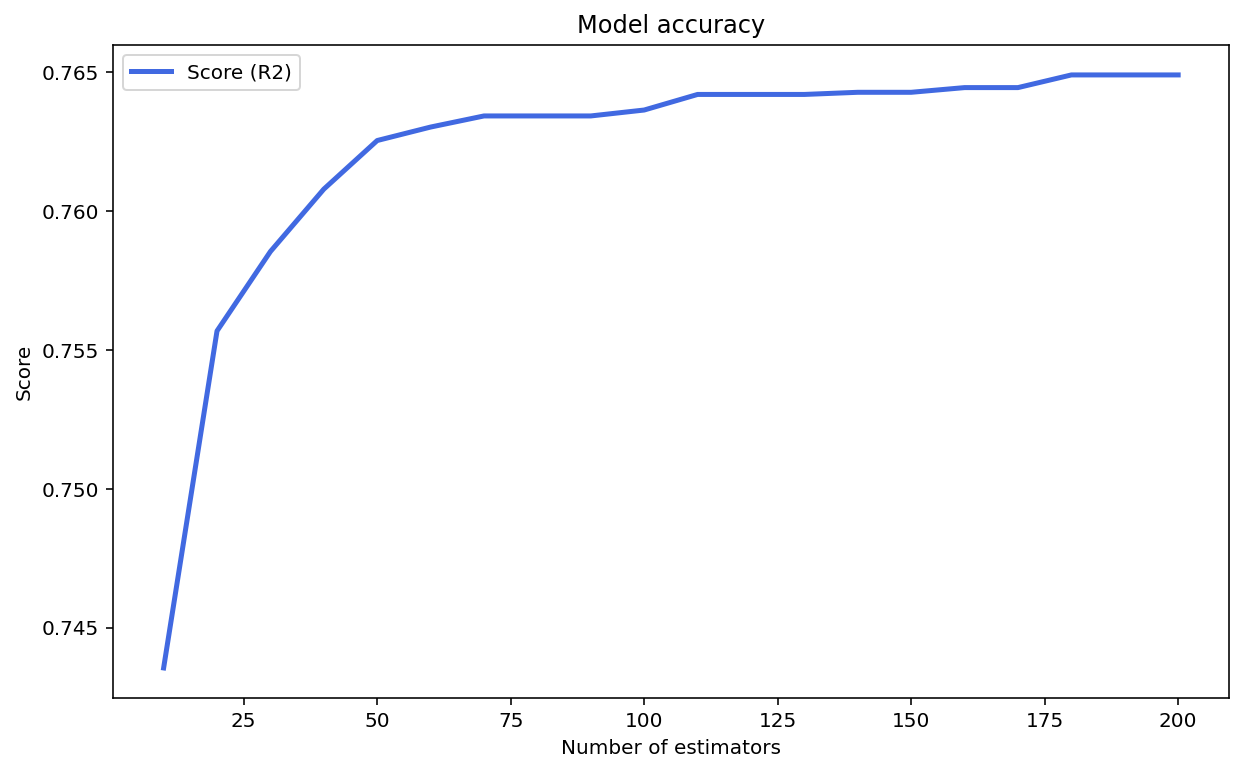

In [ ]:
# Plot
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn-deep'):
  plt.plot(
      estimators,
      scores,
      c = 'royalblue',
      linewidth = 2.5,
      label = 'Score (R2)'
  )
  plt.title('Model accuracy')
  plt.xlabel('Number of estimators')
  plt.ylabel('Score')
  plt.legend(frameon = True, facecolor = 'white')
plt.show()

In [ ]:
# Random forest regressor model
model = RandomForestRegressor(n_estimators = n_selected)
model.fit(XTrain, yTrain)

RandomForestRegressor(n_estimators=180)

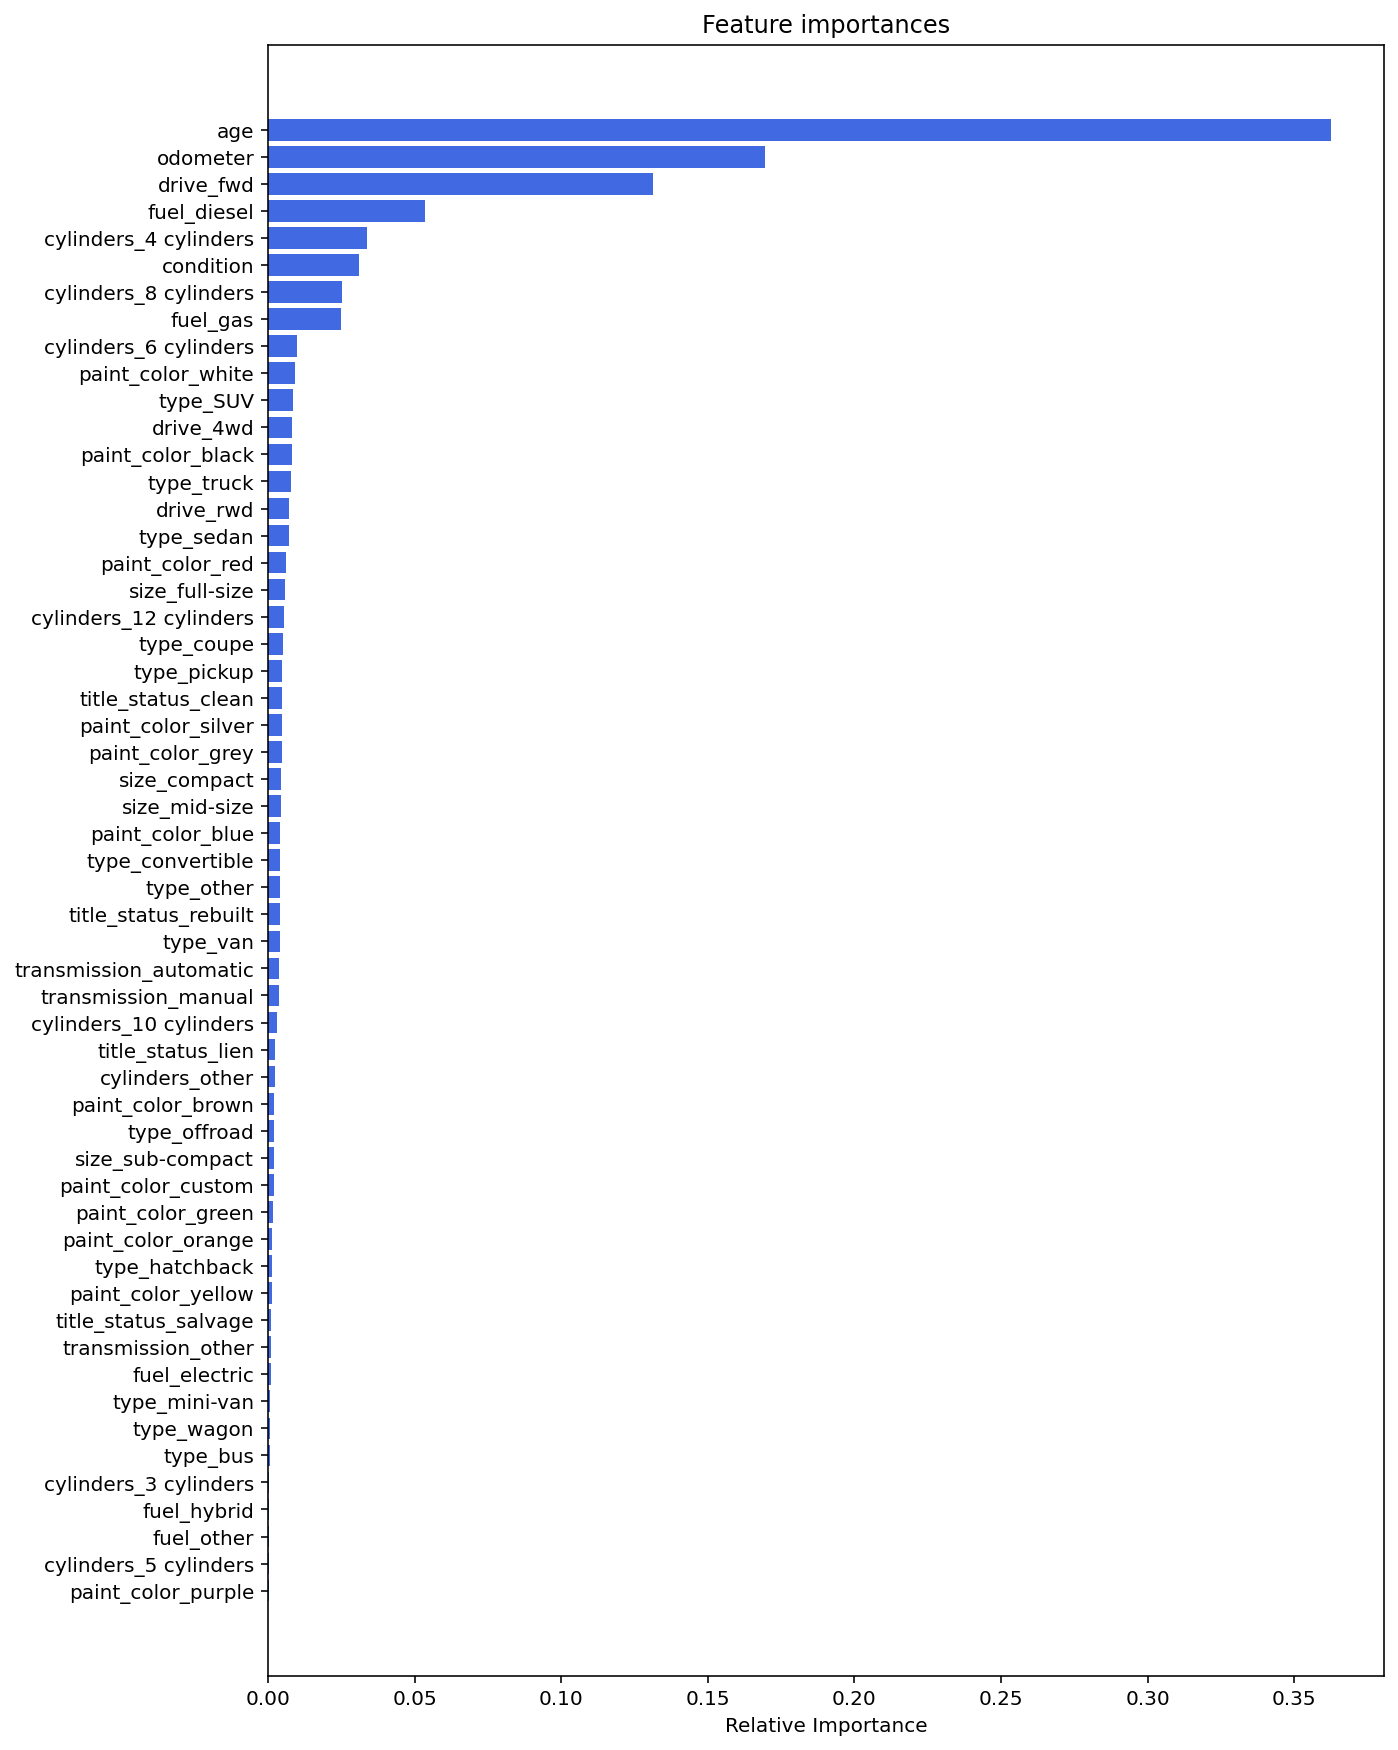

In [ ]:
# Feature importances
importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize = (10, 15))
with plt.style.context('seaborn-deep'):
  plt.barh(
      range(len(indices)),
      importances[indices],
      color = 'royalblue'
  )
  plt.title('Feature importances')
  plt.xlabel('Relative Importance')
  plt.yticks(
      range(len(indices)),
      [XTrain.columns[i] for i in indices]
  )
plt.show()

In [ ]:
# Define random sample function
def randomSample(data):
  sample = data.sample()
  pred = model.predict(sample)
  print(f'Price prediction: {pred[0]:.2f}')
  print(f'Price actual: {yTest.loc[sample.index[0]]}')
  return pred[0]

testing = randomSample(XTest)

Price prediction: 7053.61
Price actual: 9000


In [ ]:
# Double Declining Balance (DDB)
# Define DDB Function
def ddb(values, times):
  residualValues = [testing]
  for year in range(1, times + 1):
    depreciations = values * (1 / times) * 2
    values = values - depreciations
    residualValues.append(values)
  return residualValues

# Apply function 
times = 10 #Estimate for 10 years
residualEstimate = ddb(testing, times)

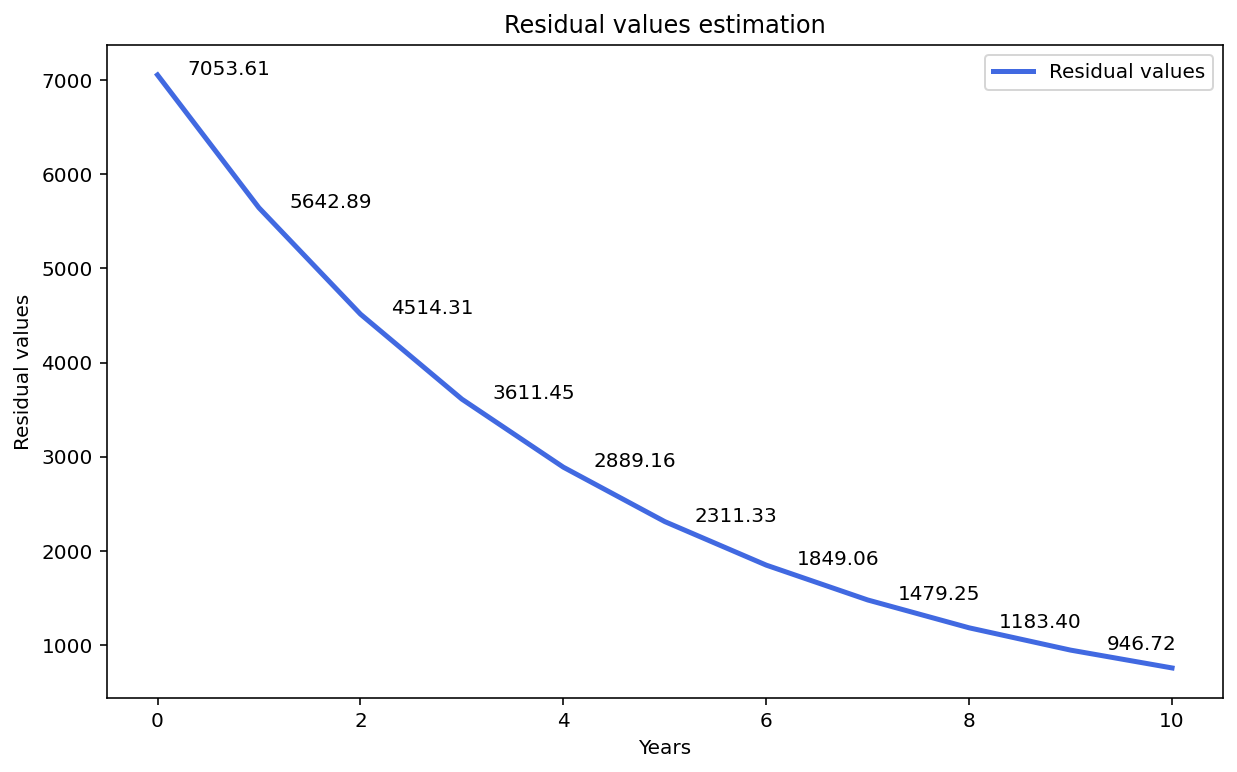

In [ ]:
# Plot
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn-deep'):
  plt.plot(
      residualEstimate,
      c = 'royalblue',
      linewidth = 2.5,
      label = 'Residual values'
  )
  # Add values to plot
  for x, y in zip(range(1, times + 1), residualEstimate):
    label = f'{y:.2f}'
    plt.annotate(
        label,
        (x, y),
        textcoords = 'offset points',
        xytext = (-15, 0),
        ha = 'center'
    )
  plt.title('Residual values estimation')
  plt.xlabel('Years')
  plt.ylabel('Residual values')
  plt.legend(frameon = True, facecolor = 'white')
plt.show()